<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/regularization/Logistic_Regression_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Logistic Regression with L2 Regularization**

In [22]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn.functional as F

In [54]:
SEED = 1

In [45]:
x,y = make_classification(n_features=2,n_redundant=0,class_sep=0.4,random_state=SEED)

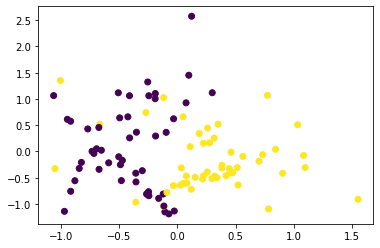

In [46]:
plt.scatter(x[:,0],x[:,1],c=y)

**L2-Regularized Logistic Regression vai weight_decay**

In [74]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, num_features):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)
    # initialize weights to zeros here,
    # since we used zero weights in the manual approach

    # self.linear.weight.detach().zero_()
    # self.linear.bias.detach().zero_()
    # note: the trailing underscore means "in-place operation"

  def forward(self,x):
    logits = self.linear(x)
    probas = torch.sigmoid(logits)
    return logits, probas


In [75]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_regions(x,y,classifier,resolution=0.02):

  # setup marker generator and color map
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # plot the decision surface
  x1_min, x1_max = x[:,0].min() - 1, x[:,0].max() + 1
  x2_min, x2_max = x[:,1].min() - 1, x[:,1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         (np.arange(x2_min, x2_max, resolution))
  )
  tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
  logits, probas = classifier.forward(tensor)

  z = np.argmax(probas.detach().numpy(), axis=1)

  z = z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  # plot class samples
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x[y==cl,0],x[y==cl,1],alpha=0.8, color=cmap(idx),edgecolor='black',marker=markers[idx],label=cl)

In [76]:
def custom_where(cond, x1, x2):
  return (cond * x1) + ((1 - cond) * x2)

def compute_accuracy(labels, pred_probas):
  pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
  acc = torch.sum(pred_labels == labels.view(-1)).float() / labels.size(0)
  return acc 

def train_single_step(model, optimizer,features, labels):
  logits, probas = model(features)

  # compute gradients
  cost = F.binary_cross_entropy(probas, labels, reduction='sum')
  optimizer.zero_grad()
  cost.backward()

  # update weights
  optimizer.step()

  # logging
  logits, pred_probas = model(features)
  acc = compute_accuracy(labels, pred_probas)  

  return acc, pred_probas

In [77]:
num_epochs = 30
LAMBDA = 0.1
x_train = torch.tensor(x, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1,1)


model = LogisticRegression(num_features=2)

# apply L2 regularization
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,weight_decay=LAMBDA)

for epoch in range(num_epochs):
  acc, pred_probas = train_single_step(model, optimizer, x_train, y_train)
  print(f'Epoch {epoch+1:03d} | Train ACC: {acc:.3f} | Cost {F.binary_cross_entropy(pred_probas, y_train,reduction="sum")}')

Epoch 001 | Train ACC: 0.810 | Cost 49.10108947753906
Epoch 002 | Train ACC: 0.860 | Cost 45.47687530517578
Epoch 003 | Train ACC: 0.790 | Cost 43.65675354003906
Epoch 004 | Train ACC: 0.870 | Cost 42.52552032470703
Epoch 005 | Train ACC: 0.850 | Cost 41.858734130859375
Epoch 006 | Train ACC: 0.870 | Cost 41.48147201538086
Epoch 007 | Train ACC: 0.850 | Cost 41.26498794555664
Epoch 008 | Train ACC: 0.870 | Cost 41.13201141357422
Epoch 009 | Train ACC: 0.850 | Cost 41.04372024536133
Epoch 010 | Train ACC: 0.860 | Cost 40.98154830932617
Epoch 011 | Train ACC: 0.850 | Cost 40.93592071533203
Epoch 012 | Train ACC: 0.860 | Cost 40.90163040161133
Epoch 013 | Train ACC: 0.860 | Cost 40.87535858154297
Epoch 014 | Train ACC: 0.860 | Cost 40.85498046875
Epoch 015 | Train ACC: 0.860 | Cost 40.83897018432617
Epoch 016 | Train ACC: 0.860 | Cost 40.826263427734375
Epoch 017 | Train ACC: 0.860 | Cost 40.81610870361328
Epoch 018 | Train ACC: 0.860 | Cost 40.80791473388672
Epoch 019 | Train ACC: 0.860 

In [98]:
def plot_decision_boundary(model, x_samples):
  x_tensor = np.vstack((np.ones_like(x_samples),x_samples))
  x_tensor = torch.tensor(x_tensor,dtype=torch.float32)
  y_tensor = model.linear.weight @ x_tensor + model.linear.bias

  x_tensor = x_tensor.detach().numpy()
  y_tensor = y_tensor.detach().numpy()
  plt.plot(x_tensor[1,:],y_tensor[0]) 

Model parameters:
 Weights: Parameter containing:
tensor([[ 4.1358, -0.4182]], requires_grad=True)
 Bias: Parameter containing:
tensor([0.2721], requires_grad=True)


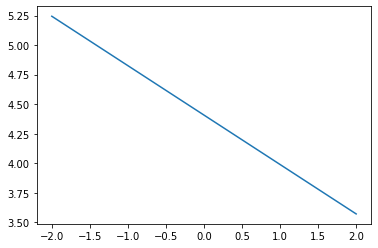

In [100]:
print(f'Model parameters:')
print(f' Weights: {model.linear.weight}')
print(f' Bias: {model.linear.bias}')
# plot_decision_regions(x,y,classifier=model)
plot_decision_boundary(model,np.linspace(-2,2))